In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from progiter import ProgIter
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# 1. Инициализация параметров

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

selected_model = 'Geotrend/distilbert-base-ru-cased'
tokenizer = AutoTokenizer.from_pretrained(selected_model)

BATCH_SIZE = 32
EPOCHS = 30
EARLY_STOP = 3
OPT = torch.optim.NAdam
LEARNING_RATE = 3e-5
EPSILON = 1e-8
SCHEDULER = False
SAMPLE = False
FINE_TUNE = False

print(device)

cuda


# 2. Функции

In [3]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Расчет метрики Hamming score, отражающей долю верно предсказанных
    элементов в объекте для задачи multi-label классификации
    '''
    acc_list = []
    
    # Цикл проходится по каждой паре таргет-предикт
    for i in range(y_true.shape[0]):
        # Для таргета и предикта создаются множества из индеков, на которых стоят единички
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None
        
        # Если оба вектора состоят толька из ноликов, то предсказание абсолютно верно, и его скор = 1
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        
        # В противном случае количество верно предсказанных единичек делится на количество элементов
        # в объединенном множесте индексов единичек таргета и предикта. Таким образом, скор будет = 1
        # только в случае, если верно найдены все единички и нет ложных единичек
        else:
            tmp_a = len(set_true.intersection(set_pred)) / float(len(set_true.union(set_pred)))

        acc_list.append(tmp_a)
    return np.mean(acc_list)


def plot_matrix(y_true, y_pred, nrows, ncols):
    '''
    Отрисовка относительных матриц несоответствий для всех классов
    '''
    f, axes = plt.subplots(nrows, ncols, figsize=(25, 15))
    axes = axes.ravel()
    matrix = multilabel_confusion_matrix(y_true, y_pred)
    
    # Цикл проходится по всем классам
    for i in range(y_true.shape[1]):
        # В целевом классе (единички) определяется процентная доля верноположительных и ложноотрицательных
        # В нецелевом классе (нолики) определяется процентная доля верноотрицательных и ложноположительных
        percentages = matrix[i] / matrix[i].sum(axis=1).reshape(2, -1)
        
        disp = ConfusionMatrixDisplay(percentages, display_labels=[0, 1])
        disp.plot(ax=axes[i], cmap=plt.cm.Blues)
        disp.ax_.set_title(f'{y_test.columns[i]} ({str(y_test.iloc[:,i].sum())})')
        if i < (ncols * (nrows - 1)):
            disp.ax_.set_xlabel('')
        if i % ncols != 0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()


def evaluate(y_true, y_pred, save_file=False, filename='filename'):
    '''
    Выведение метрик для оценки качества работы модели.
    Опционально сохранение файла с предсказаниями модели
    '''
    print('Accuracy score:', round(accuracy_score(y_true, y_pred), 3))
    print('Hamming score:', round(hamming_score(y_true, y_pred), 3), '\n')
    print(classification_report(y_true, y_pred, target_names=y_test.columns, zero_division=0))
    if save_file:
        np.savetxt(filename, y_pred.astype(int), fmt='%i', delimiter=',')

In [4]:
def make_dataset(texts, labels):
    '''
    Токенизация текстов и сопоставление токенов с идентификаторами
    соответствующих им слов. Формирование PyTorch датасета
    '''
    input_ids = []        # Список для токенизированных текстов
    attention_masks = []  # Список для масок механизма внимания
    
    # Цикл проходится и токенизирует каждый текст
    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
            sent,                        # Последовательность для токенизации
            add_special_tokens=True,     # Добавить специальные токены в начало и в конец посл-ти
            max_length=338,              # Максимальная длина последовательности
            padding='max_length',        # Токен для заполнения до максимальной длины
            return_attention_mask=True,  # Маска механизма внимания для указания на паддинги
            return_tensors = 'pt',       # Возвращать pytorch-тензоры
            truncation=True              # Обрезать последовательность до максимальной длины
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Конкатенация входных данных в тензоры
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # Преобразование таргетов в тензоры
    labels = torch.tensor(labels.values)
    # Формирование датасета
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [5]:
def train(epoch):
    '''
    Обучение одной эпохи
    '''
    print(f'Epoch {epoch+1}')
    model.train()           # Перевод модели в режим обучения
    fin_targets = []        # Список для всех таргетов обучающей выборки
    fin_outputs = []        # Список для всех предиктов модели на обучающей выборки
    total_train_loss = 0    # Лосс на обучении
    
    # Цикл проходится по батчам из обучающей выборки, Progiter отображает шкалу прогресса
    for data in ProgIter(train_dataloader):
        ids = data[0].to(device, dtype=torch.long)              # Токены последовательностей из батча
        mask = data[1].to(device, dtype=torch.long)             # Маски механизма внимания посл-тей
        targets = data[2].to(device, dtype=torch.float)         # Таргеты из батча
        
        res = model(ids, attention_mask=mask, labels=targets)   # В модель подаются входные тензоры и таргеты
        loss = res['loss']                                      # Вычисляется значение функции потерь
        logits = res['logits']                                  # Логиты предсказаний модели
        total_train_loss += loss.item()                         # Складывается лосс
        
        # Таргеты и выходы модели по батчу добавляются в списки. Логиты проходят через сигмоиду
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
        
        optimizer.zero_grad()                                   # Зануляются градиенты параметров модели
        loss.backward()                                         # По функции потерь расчитываются градиенты
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Масштабируются градиенты
        optimizer.step()                                        # Делается шаг градиентного спуска
        if SCHEDULER:                                           # При включенном шедулере корректируется
            scheduler.step()                                    # скорость обучения
    
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    predictions = np.zeros(fin_outputs.shape)
    predictions[np.where(fin_outputs >= 0.5)] = 1
    
    return total_train_loss / len(train_dataloader), fin_targets, predictions


def validate():
    '''
    Валидация обученной модели на тестовой выборке
    '''
    print(f'Validation')
    model.eval()             # Перевод модели в режим валидации
    fin_targets = []         # Список для всех таргетов валидационной выборки
    fin_outputs = []         # Список для всех предиктов модели на валидационной выборки
    total_test_loss = 0.0    # Лосс на валидации
    
    with torch.no_grad():
        # Без подсчета градиентов цикл проходится по батчам, Progiter отображает шкалу прогресса
        for data in ProgIter(test_dataloader):
            ids = data[0].to(device, dtype=torch.long)            # Токены последовательностей из батча
            mask = data[1].to(device, dtype=torch.long)           # Маски механизма внимания посл-тей
            targets = data[2].to(device, dtype=torch.float)       # Таргеты из батча
                
            res = model(ids, attention_mask=mask, labels=targets) # В модель подаются входные тензоры и таргеты
            loss = res['loss']                                    # Вычисляется значение функции потерь
            logits = res['logits']                                # Логиты предсказаний модели
            total_test_loss += loss.item()                        # Складывается лосс
            
            # Таргеты и выходы модели по батчу добавляются в списки. Логиты проходят через сигмоиду
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(logits).cpu().detach().numpy().tolist())
    
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    predictions = np.zeros(fin_outputs.shape)
    predictions[np.where(fin_outputs >= 0.5)] = 1
    
    return total_test_loss / len(test_dataloader), fin_targets, predictions

In [6]:
def log_metrics(history, writer, loss, targets, outputs, postfix):
    '''
    Расчет значений метрик и добавление их в лог обучения для отрисовки графиков.
    Добавление значений метрик в историю обучения для отрисовки временных графиков
    '''
    metrics_dict = {
        'loss': loss,
        'accuracy': metrics.accuracy_score(targets, outputs),
        'hamming': hamming_score(targets, outputs),
        'f1_score_micro': metrics.f1_score(targets, outputs, average='micro'),
        'f1_score_macro': metrics.f1_score(targets, outputs, average='macro'),
        'recall_score_micro': metrics.recall_score(targets, outputs, average='micro'),
        'recall_score_macro': metrics.recall_score(targets, outputs, average='macro'),
        'precision_score_micro': metrics.precision_score(targets, outputs, average='micro', zero_division=0.0),
        'precision_score_macro': metrics.precision_score(targets, outputs, average='macro', zero_division=0.0)
    }
    
    for metric, value in metrics_dict.items():
        if not 'macro' in metric:
            history[metric][postfix].append(value)
        writer.add_scalar(f'{metric}/{postfix}', value, epoch)


def plot_learning_curves(history):
    '''
    Отрисовка обновляющихся графиков значений метрик,
    для отслеживания в процессе обучения
    '''
    fig = plt.figure(figsize=(20, 10))
    
    for i, metric in enumerate(history.keys(), 1):
        plt.subplot(2,3,i)
        plt.title(metric, fontsize=15)
        plt.plot(range(1, epoch+2), history[metric]['train'], label='train')
        plt.plot(range(1, epoch+2), history[metric]['val'], label='val')
        plt.xticks(range(1, epoch+2))
        if i > 3:
            plt.xlabel('epoch', fontsize=15)
        plt.legend()

    plt.show()

# 3. Датасет

In [8]:
df_train = pd.read_csv('kinopoisk_train.csv')
df_test = pd.read_csv('kinopoisk_test.csv')

# При проведении экспериментов берется четверть от обучающей выборки
if SAMPLE:
    df_train = df_train.sample(frac=0.25, random_state=42)

X_train, y_train = df_train['descr_lemmas'], df_train.drop('descr_lemmas', axis=1)
X_test, y_test = df_test['descr_lemmas'], df_test.drop('descr_lemmas', axis=1)

train_dataset = make_dataset(X_train, y_train)
test_dataset = make_dataset(X_test, y_test)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 4. Модель

In [9]:
# Инициализируется предобученная модель
model = AutoModelForSequenceClassification.from_pretrained(
    selected_model,
    problem_type='multi_label_classification', # Решается задача multi-label классификации. Функция потерь BCEWithLogitsLoss
    num_labels=y_test.shape[1],                # Число классов
    output_attentions = False,                 # Модель не выдает результаты работы механизма внимания
    output_hidden_states = False               # Модель не выдает скрытые состояния
)
model.to(device)

# Если необходимо обучить только классификатор модели
if FINE_TUNE:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

# Инициализируется оптимизатор
optimizer = OPT(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON
)

# Инициализируется шедулер
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * EPOCHS
)

# Инициализируется инструмент логирования
writer = SummaryWriter(
    comment= '-' + selected_model.replace('/', '-') + f'-OP={OPT.__name__}-LR={LEARNING_RATE}-SC={SCHEDULER}-FR={SAMPLE}'
)

model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-ru-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Обучение

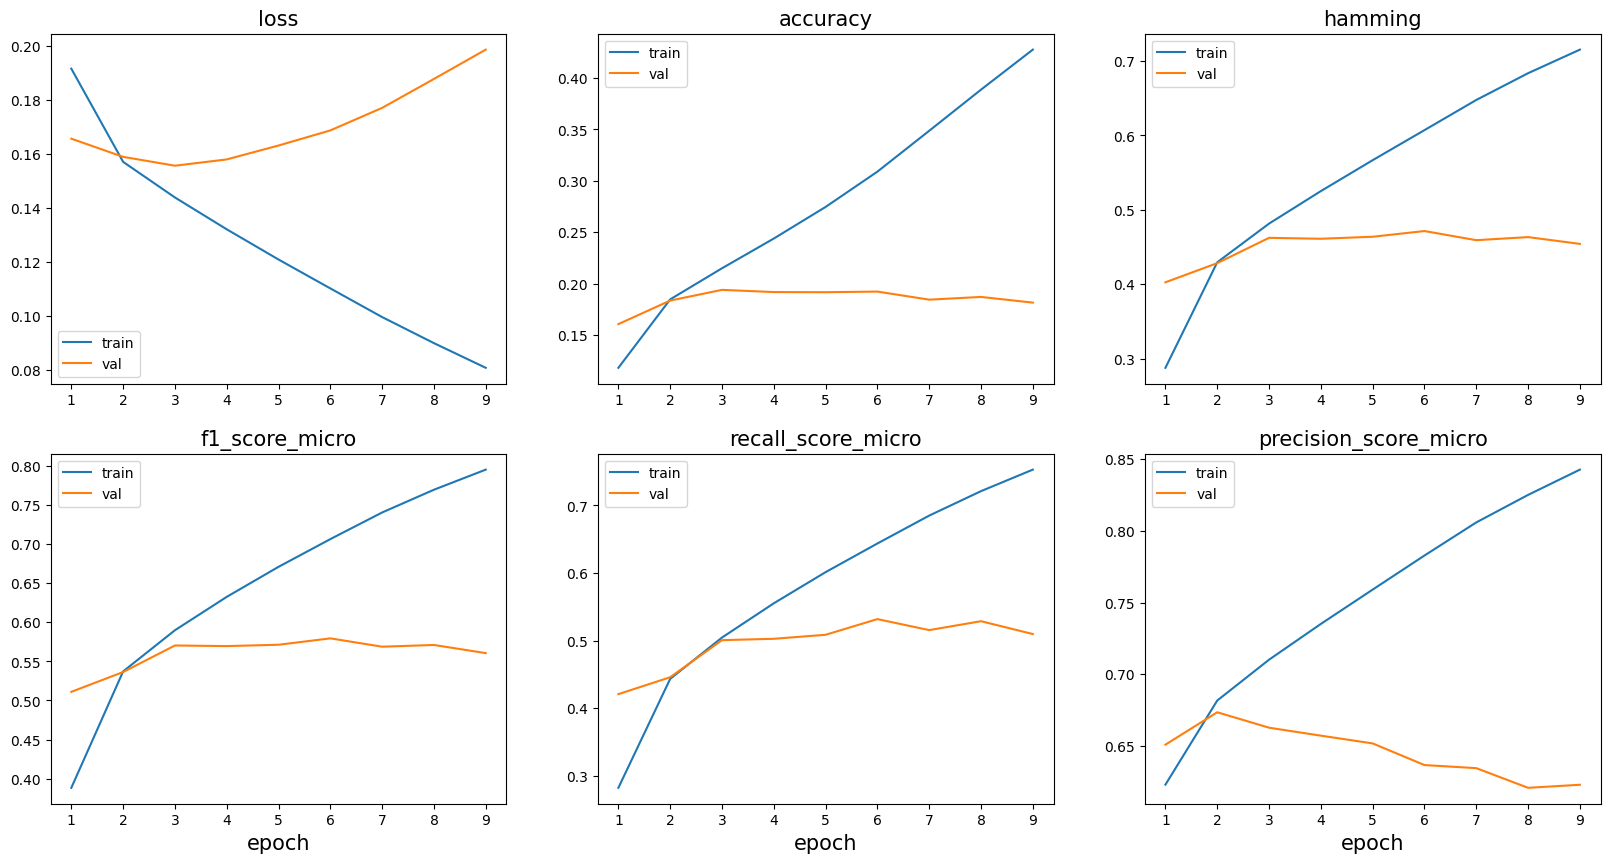

CPU times: user 3h 54min 42s, sys: 12 s, total: 3h 54min 54s
Wall time: 3h 54min 46s


In [10]:
%%time
best_f1_val = 0                                  # Переменная для хранения лучшей метрики для ранней остановки
epochs_since_best = 0                            # Переменная для отсчета количества эпох с момента лучшей метрики
history = defaultdict(lambda: defaultdict(list)) # Словарь для хранения истории метрик

for epoch in range(EPOCHS):
    
    avg_train_loss, targets, outputs = train(epoch)                         # Обучение модели на одной эпохе
    log_metrics(history, writer, avg_train_loss, targets, outputs, 'train') # Логирование метрик

    avg_val_loss, targets, outputs = validate()                             # Предсказания модели на валидационной выборке
    log_metrics(history, writer, avg_val_loss, targets, outputs, 'val')     # Логирование метрик
    
    clear_output()
    # Отрисовка кривых обучения
    plot_learning_curves(history)
    
    # Расчет micro f1-score на валидационной выборке
    f1_val = metrics.f1_score(targets, outputs, average='micro')
    # Если метрика лучше предыдущей лучшей, то сохраняется модель
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        torch.save(model, f"{selected_model.replace('/', '-')}.pt")
        epochs_since_best = 0
    # В противном случае идет отсчет эпох до ранней остановки
    else:
        epochs_since_best += 1
    if epochs_since_best == EARLY_STOP:
        break

writer.flush()
writer.close()

# 6. Оценка

In [11]:
model = torch.load(f"{selected_model.replace('/', '-')}.pt")
avg_val_loss, targets, outputs = validate()
evaluate(targets, outputs, save_file=True, filename=f"{selected_model.replace('/', '-')}.csv")

Validation
 100.00% 673/673... rate=5.61 Hz, eta=0:00:00, total=0:02:00
Accuracy score: 0.192
Hamming score: 0.471 

                 precision    recall  f1-score   support

          аниме       0.68      0.55      0.61       659
      биография       0.55      0.30      0.39       753
         боевик       0.60      0.52      0.56      2813
        вестерн       0.65      0.59      0.62       303
        военный       0.69      0.49      0.58       818
       детектив       0.55      0.34      0.42      1923
        детский       0.52      0.44      0.47       380
   для взрослых       0.00      0.00      0.00        72
 документальный       0.77      0.57      0.65      1267
          драма       0.67      0.72      0.69      9840
        история       0.58      0.28      0.38       941
        комедия       0.66      0.52      0.58      6042
короткометражка       0.63      0.50      0.56      1951
       криминал       0.60      0.54      0.57      2660
      мелодрама       0.60 

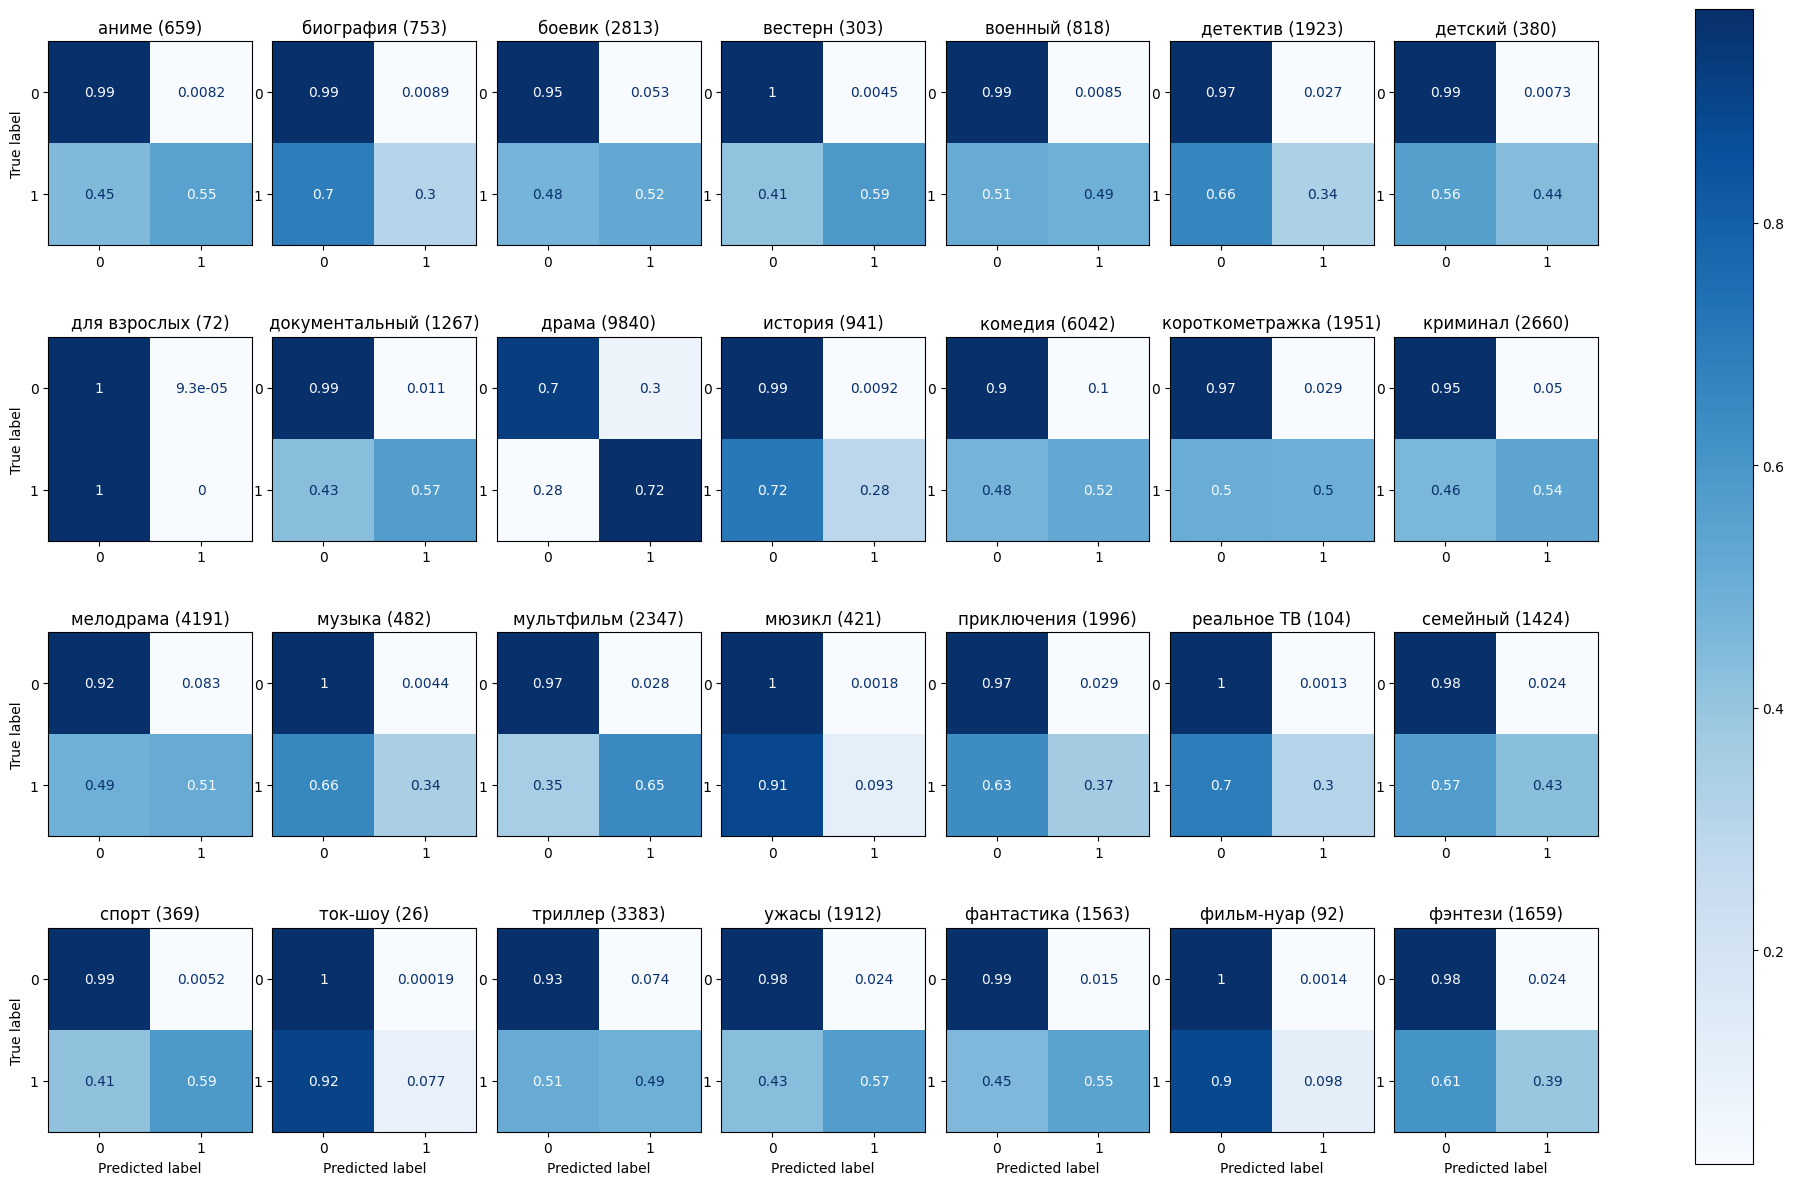

In [12]:
plot_matrix(targets, outputs, 4, 7)